<a href="https://colab.research.google.com/github/mahsaghaderan99/MLP/blob/noise-detection/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Deep* MLP project

In [434]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

#PART5

In [435]:
import tensorflow as tf
from os import path, getcwd, chdir
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

## load dataset

load mnist dataset 

In [436]:
path = f"{getcwd()}/mnist.npz"

In [437]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=path)
x_train = training_images.reshape(60000,28,28)
x_test = test_images.reshape(10000,28,28)

##Add noise

In [438]:
def add_noise(data): 
  noisy_data = np.empty(data.shape)
  for i in range(data.shape[0]):
    noisy_data[i] = random_noise(data[i],'gaussian',var=0.1)
  return noisy_data

In [439]:
noisy_train = add_noise(x_train)
noisy_test = add_noise(x_test)

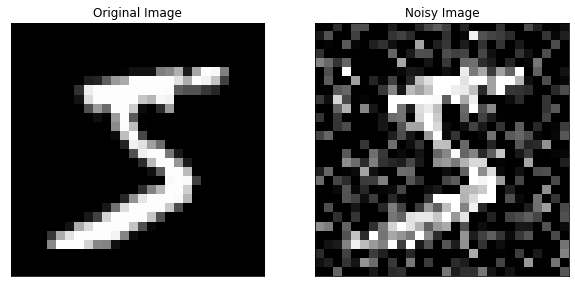

In [440]:
image_list = []
image_list.append([x_train[0], 'Original Image', 'img'])
image_list.append([noisy_train[0], 'Noisy Image', 'img'])
plotter(image_list,1,2,True,10,10)

Normalize images --> map value into (0,1)

In [441]:
noisy_train /= 255
origin_train = x_train/255
noisy_test /= 255
origin_test = x_test/255

In [442]:
m, n = x_train[0].shape[0], x_train[0].shape[1]
print(m,n)

28 28


Flatten original image --> suitable for output of the network.

In [443]:
x_train = np.reshape(noisy_train,(noisy_train.shape[0],m*n))
noisy_test = np.reshape(noisy_test,(noisy_test.shape[0],m*n))
y_train = np.reshape(origin_train,(origin_train.shape[0],m*n))
origin_test = np.reshape(origin_test,(origin_test.shape[0],m*n))

In [444]:
x_test, x_val, y_test, y_val = train_test_split(noisy_test, origin_test, test_size=0.4, random_state=42)

In [445]:
print('train shape:',x_train.shape)
print('train shape:',x_val.shape)
print('test shape:',x_test.shape)

train shape: (60000, 784)
train shape: (4000, 784)
test shape: (6000, 784)


In [446]:
import tensorflow as tf 
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs={}):
      if logs.get('accuracy')>=0.998:
          self.model.stop_training = True

callbacks = Mycallback() 

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(m*n,activation=tf.nn.relu),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,activation=tf.nn.softsign),
        tf.keras.layers.Dense(m*n,activation=tf.nn.softmax)
])
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_cosine_similarity', mode='max')
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CosineSimilarity()
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.CosineSimilarity(name='cosine_similarity')])
history = model.fit(x_train,y_train,validation_data= (x_val,y_val), epochs=85,callbacks=[mcp_save] )



Epoch 1/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.6634 - cosine_similarity: 0.6634 - val_loss: -0.7355 - val_cosine_similarity: 0.7355
Epoch 2/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.7650 - cosine_similarity: 0.7650 - val_loss: -0.8016 - val_cosine_similarity: 0.8016
Epoch 3/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.8087 - cosine_similarity: 0.8087 - val_loss: -0.8295 - val_cosine_similarity: 0.8295
Epoch 4/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.8282 - cosine_similarity: 0.8282 - val_loss: -0.8458 - val_cosine_similarity: 0.8458
Epoch 5/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.8396 - cosine_similarity: 0.8396 - val_loss: -0.8556 - val_cosine_similarity: 0.8556
Epoch 6/85
1875/1875 [==============================] - 4s 2ms/step - loss: -0.8481 - cosine_similarity: 0.8481 - val_loss: -0.8652 - val_cosine_similarity: 0.8652
Epoch 7/85
1875/

In [447]:
model.load_weights('.mdl_wts.hdf5')

In [448]:
print(model.evaluate(x_test, x_test))

188/188 [==============================] - 0s 2ms/step - loss: -0.7683 - cosine_similarity: 0.7683
[-0.7683223485946655, 0.7683223485946655]


In [449]:
y_pred = model.predict(x_test)
y_pred0 = np.reshape(y_pred,(y_pred.shape[0],m,n))

In [450]:
s = 3822

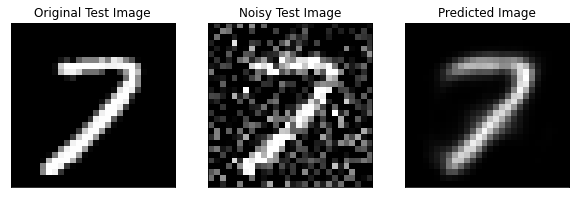

In [451]:
image_list = []
image_list.append([y_test[s].reshape((m,n)), 'Original Test Image', 'img'])
image_list.append([x_test[s].reshape((m,n)), 'Noisy Test Image', 'img'])
image_list.append([y_pred0[s], 'Predicted Image', 'img'])
plotter(image_list,1,3 ,True,10,10)

In [452]:
np.max(y_val)

1.0